# Introducing Buffer Pool Parallel Scan

## <u>Buffer Pool Scan Performance Improvements</u>

In SQL Server 2019 and previous releases, operations that require scanning the buffer pool can slow, especially on larger memory machines. 

An example of a large machine, with large amounts of processing and memory consider an M-series Azure SQL Virtual Machine or an HP DL580, as was used in this example.

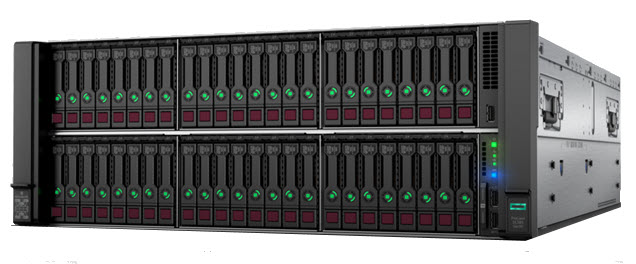  

The impact can be noticed on operations such as:

- Creating a new databases
- Backup/restore operations
- AlwaysOn failover events
- File drop operations
- DBCC CHECKDB and DBCC CHECKTABLE operations
- Other internal operations (e.g., checkpoint)

The reason for the overhead is that scanning the buffer pool in SQL Server 2019 and earlier releases, is a serial operation, and the larger the machine, the greater the impact.

In SQL Server 2022, the Buffer Pool Parallel Scan feature improves performance of Buffer Pool scan operations by utilizing multiple CPU cores. 

This is a general benefit that many customers will witness simply by upgrading to SQL Server 2022.

**Note:** This demo requires a larger memory machine, at least a machine with 100GBs, but ideally with 1TB or larger to simulate long buffer pool scans. 

This demo will walk through buffer pool scans versus BP parallel scans along with the extended event telemetry.

## **Part 1:** Examining SQL Server Memory and Populating the Buffer Pool

**1).** First we will evaluate the amount of memory on the server.

In [1]:
EXEC sp_configure 'max server memory'; -- the current value
GO

Commands completed successfully.

Total execution time: 00:00:00.135

name,minimum,maximum,config_value,run_value
max server memory (MB),128,2147483647,1843200,1843200


**Note:** In this example we have, 1.84 TB of the 2 TBs available on this HL580 server, devoted to the SQL Server buffer pool.

**2).** In this next step we will populate buffers in the buffer pool by loading pages from a restored database **BPoolScanTestLargeDB** (1.26 TBs).  
In this example we will load at least 64 GBs into memory.

In [ ]:
SET NOCOUNT ON

USE [BPoolScanTestLargeDB]
GO

-- List all the tables.
/*SELECT name from sys.objects WHERE type = 'U' and name LIKE 't%' 
ORDER BY name
GO*/

-- Load all the rows/pages from the tables.
-- Change @table_count accordingly depending on how many buffers to load (4GB/table).
-- For example, 16 for 64GB; 256 for 1TB.
DECLARE @table_count as int
DECLARE @i as int
DECLARE @cmd as nvarchar(200)
SET @table_count = 256
SET @i = 1
WHILE @i <= @table_count
BEGIN
	SET @cmd = 'SELECT SUM(price) as sum from t' + FORMAT(@i, 'd4')
	--PRINT @cmd
	EXECUTE(@cmd)
	SET @i = @i + 1
END;
GO

**3).** Now that we have loaded data into the buffer pool for this demo, let's now verify the amount of data that has been loaded.

As can be seen below, there is **1054.05 GBs** of database pages in cache.

In [19]:
-- The BufferPool memory usage
SELECT	counter_name,
		cntr_value AS value,
		size_mb =
			case counter_name
				WHEN 'Database pages'				THEN cntr_value*8/1024
				WHEN 'Database Cache Memory (KB)'	THEN cntr_value/1024
				WHEN 'Total Server Memory (KB)'		THEN cntr_value/1024
				WHEN 'Target Server Memory (KB)'	THEN cntr_value/1024
				ELSE NULL
			END
FROM sys.dm_os_performance_counters
WHERE instance_name = '' AND counter_name IN ('Database Cache Memory (KB)', 'Target Server Memory (KB)', 'Total Server Memory (KB)', 'Database pages');
GO


Commands completed successfully.

Total execution time: 00:00:00.139

counter_name,value,size_mb
Database pages,134918319,1054049
Database Cache Memory (KB),1079346552,1054049
Target Server Memory (KB),1859879784,1816288
Total Server Memory (KB),1859879784,1816288


So, we can see in the result above that we have 1.054049 terabytes used for the database page cache.  (134,918,272 data pages).

## **Part 2:** Comparing Serial Buffer Pool Scans versus the SQL Server 2022 Buffer Pool Parallel Scan improvement

**4).** In the examples below we will compare and contrast serial buffer pool scan (SQL 2019, and below) and **parallel buffer pool scan** (SQL 2022) performance.

In order to run buffer pool scans in serial mode, we will use trace flag 892.

It should be noted that **buffer pool parallel scan** is on by default.

In the first example we will compare the performance of <u>**creating a database**</u> and the impact to scanning the buffer pool.

In [20]:
-- Force using buffer pool scans to use a serial scan:
DBCC TRACEON(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

-- CREATE DATABASE (runs FlushCache)
CREATE DATABASE testdb1
GO

CREATE TABLE testdb1.dbo.t1 (id int, c char(8000))
GO

DECLARE @i AS int
SET @i = 0
SET NOCOUNT ON
WHILE @i < 100
BEGIN
    INSERT INTO testdb1.dbo.t1 VALUES (1, 'apple')
    SET @i = @i + 1
END;
GO

DBCC execution completed. If DBCC printed error messages, contact your system administrator.

Commands completed successfully.

Total execution time: 00:00:10.188

In [21]:
-- Force using buffer pool scans to use a parallel scan:
DBCC TRACEOFF(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

-- CREATE DATABASE (runs FlushCache)
CREATE DATABASE testdb2
GO

CREATE TABLE testdb2.dbo.t1 (id int, c char(8000))
GO

DECLARE @i AS int
SET @i = 0
SET NOCOUNT ON
WHILE @i < 100
BEGIN
    INSERT INTO testdb2.dbo.t1 VALUES (1, 'apple')
    SET @i = @i + 1
END;
GO

DBCC execution completed. If DBCC printed error messages, contact your system administrator.

Commands completed successfully.

Total execution time: 00:00:01.070

### **<u>Comparison</u>**

We can see that the total execution time for a serial buffer pool scan is <mark>10.188 seconds</mark> and the total execution time for parallel buffer pool scans is just over a second at <mark>01.070 seconds</mark>. This is an improvement of **89.4974%**.

**5).** In the example below we will compare and contrast serial buffer pool scan (SQL 2019, and below) and **parallel buffer pool scan** (SQL 2022) performance of:

<u>**Database Maintenance Operations** (DBCC CHECKDB and CHECKTABLE)</u>:

In [25]:
-- Force using buffer pool scans to use a serial scan:
DBCC TRACEON(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

-- DBCC CHECKDB tests:
DBCC CHECKDB('testdb1') WITH NO_INFOMSGS, ALL_ERRORMSGS
GO

DBCC CHECKDB('testdb2') WITH NO_INFOMSGS, ALL_ERRORMSGS
GO

DBCC CHECKDB('BPoolScanTestLargeDB') WITH NO_INFOMSGS, ALL_ERRORMSGS
GO

-- DBCC CHECKTABLE tests:
DBCC CHECKTABLE('testdb1.dbo.t1') WITH NO_INFOMSGS, ALL_ERRORMSGS
GO

DBCC CHECKTABLE('testdb2.dbo.t1') WITH NO_INFOMSGS, ALL_ERRORMSGS
GO

DBCC execution completed. If DBCC printed error messages, contact your system administrator.

Commands completed successfully.

Total execution time: 00:37:19.090

In [26]:
-- Force using buffer pool scans to use a parallel scan:
DBCC TRACEOFF(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

-- DBCC CHECKDB tests:
DBCC CHECKDB('testdb1') WITH NO_INFOMSGS, ALL_ERRORMSGS;
GO

DBCC CHECKDB('testdb2') WITH NO_INFOMSGS, ALL_ERRORMSGS;
GO

DBCC CHECKDB('BPoolScanTestLargeDB') WITH NO_INFOMSGS, ALL_ERRORMSGS;
GO

-- DBCC CHECKTABLE tests:
DBCC CHECKTABLE('testdb1.dbo.t1') WITH NO_INFOMSGS, ALL_ERRORMSGS;
GO

DBCC CHECKTABLE('testdb2.dbo.t1') WITH NO_INFOMSGS, ALL_ERRORMSGS;
GO

DBCC execution completed. If DBCC printed error messages, contact your system administrator.

Commands completed successfully.

Total execution time: 00:26:50.894

### **<u>Comparison</u>**

We can see that the total execution time for a serial buffer pool scan is <mark>37:19 minutes</mark> and the total execution time for parallel buffer pool scans is <mark>26:51 minutes</mark>. This is an improvement of **28.05%**.

**6).** In the example below we will compare and contrast serial buffer pool scan (SQL 2019, and below) and **parallel buffer pool scan** (SQL 2022) performance of:

**<u>Database Failover Simulation</u>**:

In [6]:
-- Force using buffer pool scans to use a serial scan:
DBCC TRACEON(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

-- DB shutdown (offline)
ALTER DATABASE testdb1 SET offline
go
ALTER DATABASE testdb1 SET online
go

--Simulate a failover; shutdown event
ALTER DATABASE [BPoolScanTestLargeDB] SET offline
go
ALTER DATABASE [BPoolScanTestLargeDB] SET online
go

DBCC execution completed. If DBCC printed error messages, contact your system administrator.

Commands completed successfully.

Total execution time: 00:02:21.377

In [7]:
-- Force using buffer pool scans to use a parallel scan:
DBCC TRACEOFF(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

-- DB shutdown (offline)
ALTER DATABASE testdb1 SET offline
go
ALTER DATABASE testdb1 SET online
go

--Simulate a failover; shutdown event
ALTER DATABASE [BPoolScanTestLargeDB] SET offline
go
ALTER DATABASE [BPoolScanTestLargeDB] SET online
go


DBCC execution completed. If DBCC printed error messages, contact your system administrator.

Commands completed successfully.

Total execution time: 00:00:02.495

### **<u>Comparison</u>**

We can see that the total execution time for a serial buffer pool scan is <mark>02:21 minutes</mark> and the total execution time for parallel buffer pool scans is just over <mark>00:02.46 seconds</mark>.

This is an improvement of **98.26%**.

**7).** In the example below we will compare and contrast serial buffer pool scan (SQL 2019, and below) and **parallel buffer pool scan** (SQL 2022) performance of:

**<u>Database File Operations</u>**:

In [9]:
-- Force using buffer pool scans to use a serial scan:
DBCC TRACEON(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

-- add and drop files
ALTER DATABASE testdb1 ADD FILE (NAME='data2', FILENAME='e:\data\testdb1_data2.mdf', SIZE=8MB)
ALTER DATABASE testdb1 REMOVE FILE data2
go

DROP DATABASE testdb1
go

DBCC execution completed. If DBCC printed error messages, contact your system administrator.

The file 'data2' has been removed.

Commands completed successfully.

Total execution time: 00:00:25.934

In [10]:
-- Force using buffer pool scans to use a parallel scan:
DBCC TRACEOFF(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

-- add and drop files
ALTER DATABASE testdb2 ADD FILE (NAME='data2', FILENAME='e:\data\testdb2_data2.mdf', SIZE=8MB)
ALTER DATABASE testdb2 REMOVE FILE data2
GO

DROP DATABASE testdb2
GO

DBCC execution completed. If DBCC printed error messages, contact your system administrator.

The file 'data2' has been removed.

Commands completed successfully.

Total execution time: 00:00:01.606

### **<u>Comparison</u>**

We can see that the total execution time for a serial buffer pool scan is <mark>00:25.6 seconds</mark> and the total execution time for parallel buffer pool scans is just over <mark>00:01.61 seconds</mark>.

This is an improvement of **93.71%**.

## **Part 3:** Examining Buffer Pool Parallel Scan Extended Events

**9).** In the example below we will rerun our workloads, but this time we will be using extended events and will 'Watch the Live' events using SQL Server Management Studio (SSMS).

First we will create the extended event session and then will start the session:

In [ ]:
-------------------------------------------------------------------------------
-- BufferPool Parallel Scan test
--
-- The test requires a large-memory machine (at least 100GB, ideally 1TB or bigger)
-- to simulate long BufferPool scans.
-------------------------------------------------------------------------------

-- Capture Extended Events
-- Change the filename appropriately.

-- major events
CREATE EVENT SESSION [buffer_pool_scan_test] ON SERVER 
ADD EVENT sqlserver.buffer_pool_scan_complete    (ACTION(sqlserver.session_id,sqlserver.sql_text)),
ADD EVENT sqlserver.buffer_pool_scan_task_error  (ACTION(sqlserver.session_id)),
ADD EVENT sqlserver.buffer_pool_flush_cache      (ACTION(sqlserver.session_id,sqlserver.sql_text))
ADD TARGET package0.event_file(SET filename=N'c:\temp\buffer_pool_scan_test.xel'),
ADD TARGET package0.ring_buffer
WITH (STARTUP_STATE=ON)
GO

--Ensure that the extended event session has been started
ALTER EVENT SESSION [buffer_pool_scan_test] ON SERVER
STATE = START
GO

**10).** Now we will right click the extended event session and click 'Watch Live Data'.

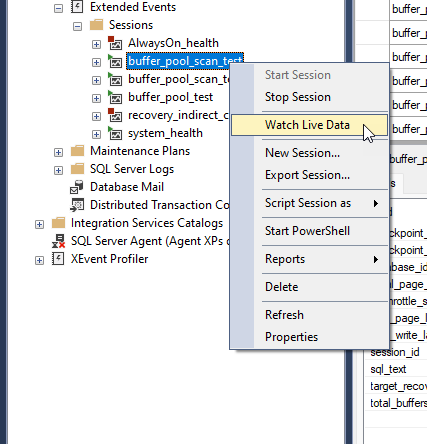

**11).** Next we will run some of the workloads as before, but we will <u>start with parallel mode</u>.

In [ ]:
-------------------------------------------------------------------------------
-- Run some buffer pool scan scenarios in parallel mode
-------------------------------------------------------------------------------
-- Use parallel scan
DBCC TRACEOFF(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

USE [tempdb]
GO

-- FlushCache
DBCC FLUSH('data', 'BPoolScanTestLargeDB')
GO

-- CheckTable
DBCC CHECKTABLE('BPoolScanTestLargeDB.dbo.t0001')
GO

-- CREATE DATABASE (runs FlushCache)
CREATE DATABASE testdb3
GO

CREATE TABLE testdb3.dbo.t1 (id int, c char(8000))
GO

DECLARE @i AS int
SET @i = 0
SET NOCOUNT ON
WHILE @i < 100
BEGIN
    INSERT INTO testdb3.dbo.t1 VALUES (1, 'burger')
    SET @i=@i+1
END
GO

-- FlushCache
DBCC FLUSH('data', 'testdb3')
GO

-- CheckDB
DBCC CHECKDB('testdb3')
GO

-- CheckTable
DBCC CHECKTABLE('testdb3.dbo.t1')
GO

-- drop files
ALTER DATABASE testdb3 ADD FILE (name='data2', filename='e:\data\testdb3_data2.mdf', size=8MB)
ALTER DATABASE testdb3 remove file data2
GO

-- Backup (runs FlushCache)
BACKUP DATABASE testdb3 TO DISK='nul'
GO

-- DB shutdown (offline)
ALTER DATABASE testdb3 SET OFFLINE
GO

ALTER DATABASE testdb3 SET ONLINE
GO

DROP DATABASE testdb3
GO

ALTER DATABASE [BPoolScanTestLargeDB] SET OFFLINE
GO

ALTER DATABASE [BPoolScanTestLargeDB] SET ONLINE
GO

**12).** Now, for comparison we will run the same workload in <u>serial mode</u>.

In [ ]:
-------------------------------------------------------------------------------
-- Run some buffer pool scans scenarios in serial mode 
-------------------------------------------------------------------------------
-- Use serial scan
DBCC TRACEON(892, -1) -- BPSCAN_PARALLEL_SCAN_OFF
GO

USE [tempdb]
GO

-- FlushCache
DBCC FLUSH('data', 'BPoolScanTestLargeDB')
GO

-- CheckTable
DBCC CHECKTABLE('BPoolScanTestLargeDB.dbo.t0001')
GO

-- CREATE DATABASE (runs FlushCache)
CREATE DATABASE testdb3
GO

CREATE TABLE testdb3.dbo.t1 (id int, c char(8000))
GO

DECLARE @i AS int
SET @i = 0
SET NOCOUNT ON
WHILE @i < 100
BEGIN
    INSERT INTO testdb3.dbo.t1 VALUES (1, 'burger')
    SET @i=@i+1
END
GO

-- FlushCache
DBCC FLUSH('data', 'testdb3')
GO

-- CheckDB
DBCC CHECKDB('testdb3')
GO

-- CheckTable
DBCC CHECKTABLE('testdb3.dbo.t1')
GO

-- drop files
ALTER DATABASE testdb3 ADD FILE (name='data2', filename='e:\data\testdb3_data2.mdf', size=8MB)
ALTER DATABASE testdb3 remove file data2
GO

-- Backup (runs FlushCache)
BACKUP DATABASE testdb3 TO DISK='nul'
GO

-- DB shutdown (offline)
ALTER DATABASE testdb3 SET OFFLINE
GO

ALTER DATABASE testdb3 SET ONLINE
GO

DROP DATABASE testdb3
GO

ALTER DATABASE [BPoolScanTestLargeDB] SET OFFLINE
GO

ALTER DATABASE [BPoolScanTestLargeDB] SET ONLINE
GO

**13).** Now that both workloads have been run, go back to the <u>'Watch Live Events'</u> tab and click to bring **parallel\_tasks** and **elapsed\_time\_ms.**

The nonzero parallel\_tasks are queries and workloads that ran as buffer pool parallel tasks. 

The larger elapsed\_time\_ms queries, all with 0 parallel tasks, were run in serial mode.

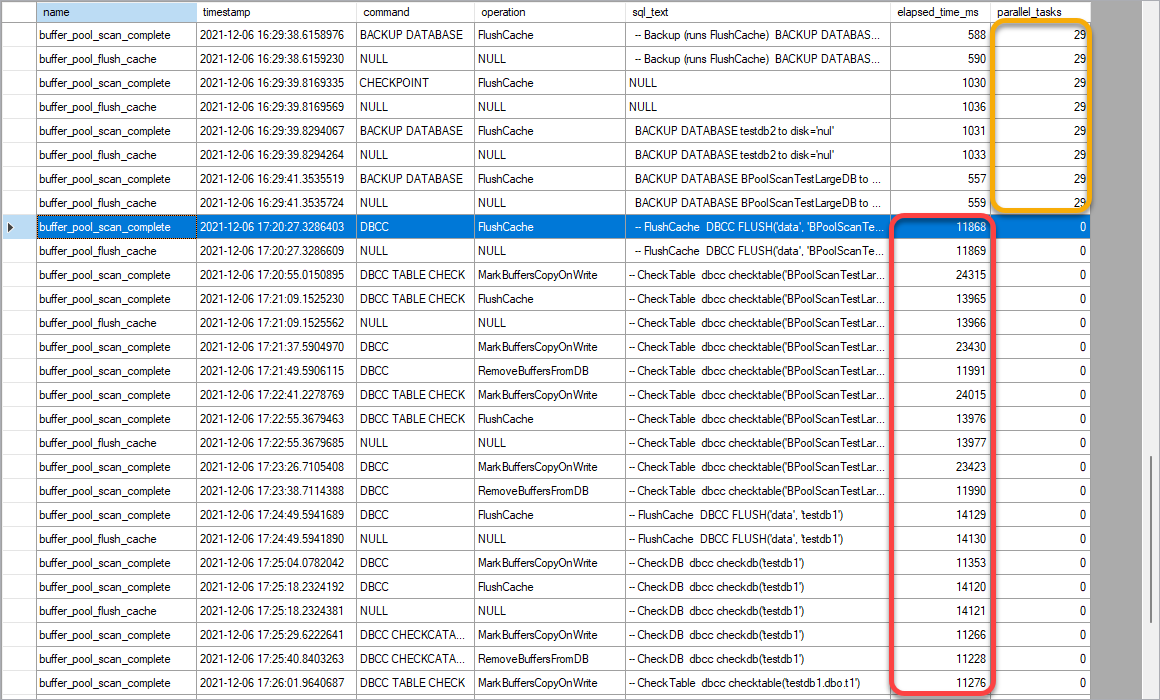

**14).** Additionally, we can scan the SQL Server error log and look for any Buffer Pool scans that take longer than 10 seconds.

In the example below, we can see that an ALTER DATABASE event took 186 seconds to complete.

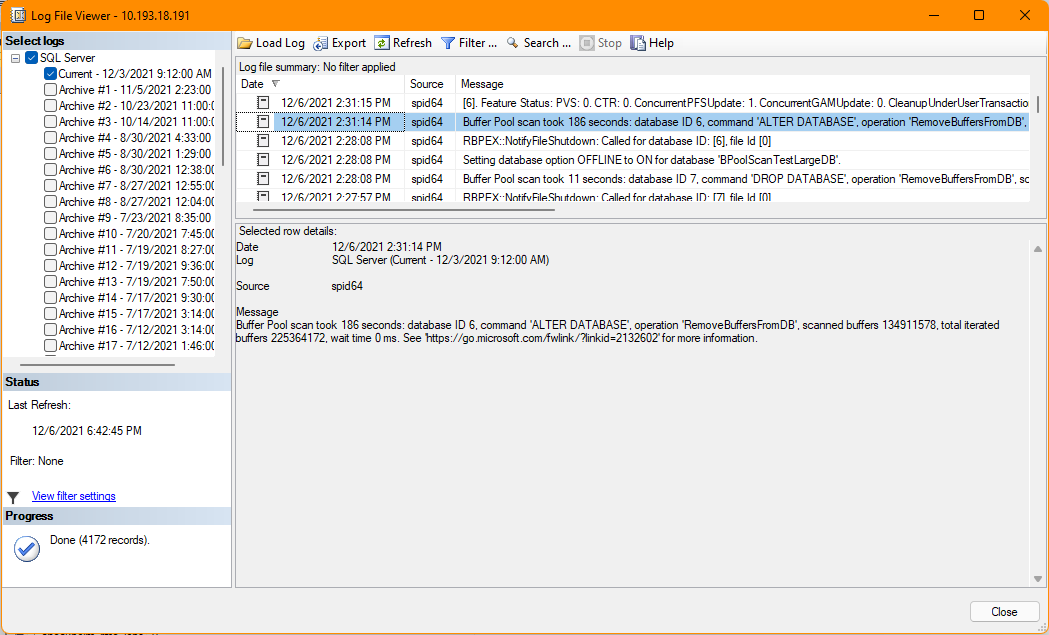